In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [2]:
# Read data from csv files into DataFrame "merged_all"
merged_all = pd.read_csv(r'C:\Users\HT\OneDrive - ueh.edu.vn\Máy tính\Data Mining\final project\Data\merged_all.csv')

# Display the first 5 rows of DataFrame "merged_all"
merged_all.head()

,Loại hợp đồng,Số người phụ thuộc,Địa chỉ thường trú,Ngành,Nghề nghiệp,Địa chỉ công ty (tỉnh thành),ID hợp đồng,Cân nặng,Trình độ học vấn,Doanh thu,...,Tiền phạt quá hạn (VND),Số ngày quá hạn hợp đồng,Khách hàng quá hạn (ngày),Ngày trả,Khoản trả,Trễ hạn (tháng),Lịch sử quá hạn (hợp đồng),Thanh toán (tháng),Lịch sử quá hạn (khách hàng),Nhóm quá hạn
0,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,B0
1,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-07-08 00:00:00.000,588.784058,0.0,0.0,1.0,0.0,B0
2,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-08-08 00:00:00.000,585.946528,0.0,0.0,2.0,0.0,B0
3,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-09-12 00:00:00.000,583.095189,1.0,2.0,3.0,2.0,B0
4,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-10-03 00:00:00.000,584.522597,1.0,2.0,4.0,2.0,B0


In [6]:
ex = merged_all[['ID hợp đồng','Thanh toán (tháng)','Nhóm quá hạn']].copy()

ex1 = ex[ex['Thanh toán (tháng)']<3]
ex2 = ex[(ex['Thanh toán (tháng)']<3) & (ex['Nhóm quá hạn'] != 'B0')]

counts_2m = ex1.groupby('ID hợp đồng').size().reset_index(name='n_records')
counts_OD_2m = ex2.groupby('ID hợp đồng').size().reset_index(name='n_records')

OD_2m_ratio = counts_OD_2m.shape[0]/counts_2m.shape[0]
print(f"Tỉ lệ hợp đồng trễ hạn trong 2 tháng đầu kể từ ngày giải ngân là: {round(OD_2m_ratio, 2) *100}%")

Tỉ lệ hợp đồng trễ hạn trong 2 tháng đầu kể từ ngày giải ngân là: 8.0%


In [ ]:
#Nhóm để ý trong 2 tháng đầu kể từ ngày giải ngân thì số lượng hợp đồng trả không đúng hạn chiếm rất nhỏ
buf = merged_all[merged_all['Thanh toán (tháng)'] >= 3].copy()

buf['Thanh toán (tháng tiếp theo)'] = buf['Thanh toán (tháng)'] + 1
supbuf = buf[['ID hợp đồng','Thanh toán (tháng)','Nhóm quá hạn','Số ngày quá hạn hợp đồng']].copy()

In [8]:
# tạo dataframe merge buf với supbuf để lấy thông tin tháng tiếp theo
buf = buf.merge(
    right=supbuf,
    right_on=['ID hợp đồng', 'Thanh toán (tháng)'],
    left_on=['ID hợp đồng', 'Thanh toán (tháng tiếp theo)'],
    how='left'   # hoặc 'inner' tùy mục đích
)

# Lọc dữ liệu theo điều kiện để lấy nhóm đang tốt ở tháng hiện tại
buf = buf[
    (buf['Thanh toán (tháng)_x'] < 12) &
    (buf['Nhóm quá hạn_x'] == 'B0') &
    (buf['Số ngày quá hạn hợp đồng_y'] <= 30) #
].copy()

# Tạo cột kết quả chuyển đổi từ B0 sang nhóm nợ xấu
buf['ROLL'] = np.where(buf['Số ngày quá hạn hợp đồng_y'] == 0, 0, 1)

# Kiểm tra tỉ lệ các giá trị trong cột ROLL
buf['ROLL'].value_counts()

0    308117
1     20485
Name: ROLL, dtype: int64

In [9]:
# Chuẩn hóa lại tên cột trong DataFrame "buf"
buf.drop(columns=['Thanh toán (tháng)_y','Nhóm quá hạn_y','Số ngày quá hạn hợp đồng_y'], inplace=True)
buf.columns = ['_'.join(col[:-1]) if 'x' in col else '_'.join(col) for col in buf.columns.str.split('_').values]

Chọn Feature

1. Chọn tất cả biến có tương quan cao với biến Target(ROLL)

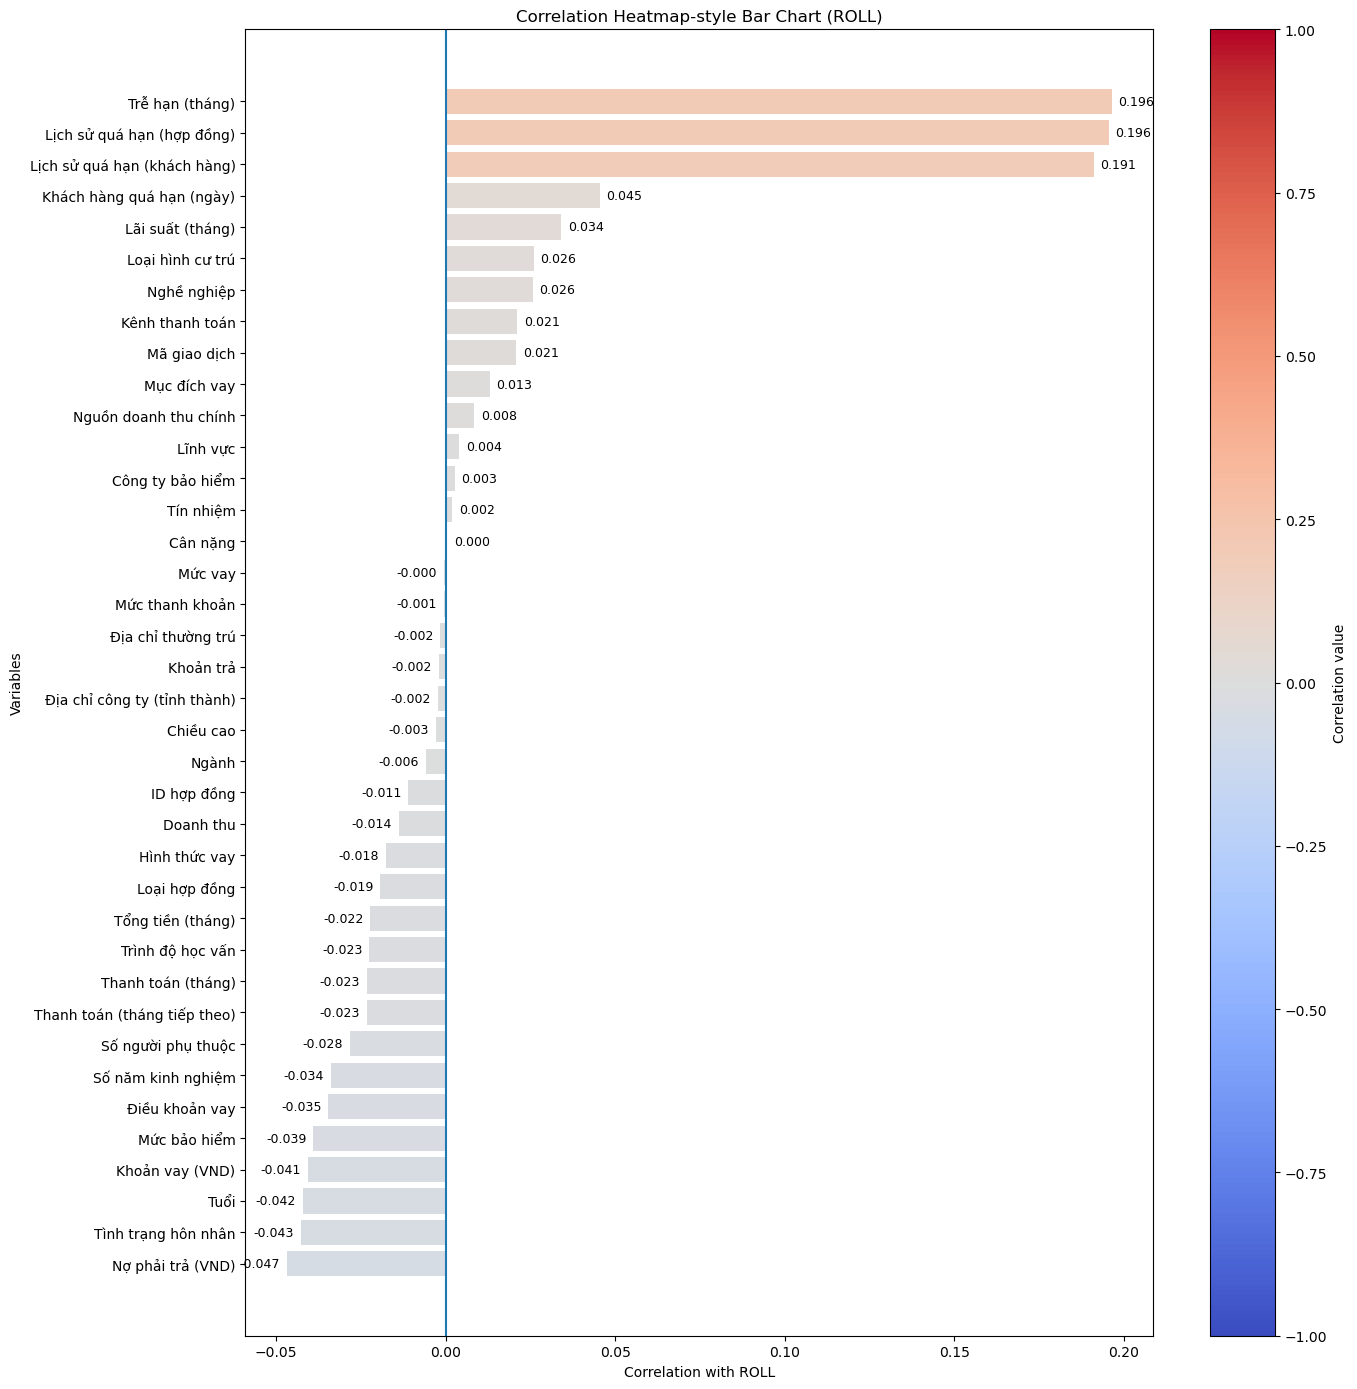

In [12]:
# Vẽ biểu đồ thanh thể hiện correlation giữa các biến số với biến mục tiêu ROLL
# 1. Chỉ lấy các cột số
num_df = buf.select_dtypes(include="number")

# 2. Correlation với ROLL
corr_roll = (
    num_df.corr()["ROLL"]
    .drop("ROLL")
    .dropna()
    .sort_values()
)

# 3. Colormap heatmap
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = plt.cm.coolwarm
colors = cmap(norm(corr_roll.values))

# 4. Figure & Axes
fig, ax = plt.subplots(figsize=(14, 14))

bars = ax.barh(corr_roll.index, corr_roll.values, color=colors)
ax.axvline(0)

ax.set_xlabel("Correlation with ROLL")
ax.set_ylabel("Variables")
ax.set_title("Correlation Heatmap-style Bar Chart (ROLL)")

# 5. Thêm value trên đầu mỗi cột
for bar, value in zip(bars, corr_roll.values):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    # Nếu correlation dương → chữ bên phải, âm → bên trái
    if value >= 0:
        ax.text(x + 0.002, y, f"{value:.3f}", va="center", ha="left", fontsize=9)
    else:
        ax.text(x - 0.002, y, f"{value:.3f}", va="center", ha="right", fontsize=9)

# 6. Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Correlation value")

plt.tight_layout()
plt.show()


In [13]:
high_corr_features = corr_roll[abs(corr_roll) > 0.014].index.tolist()
features = high_corr_features + ['Doanh thu','Nguồn doanh thu chính']
features

buf = buf[features + ['ROLL']].copy()

In [25]:
high_corr_features

['Nợ phải trả (VND)',
 'Tình trạng hôn nhân',
 'Tuổi',
 'Khoản vay (VND)',
 'Mức bảo hiểm',
 'Điều khoản vay',
 'Số năm kinh nghiệm',
 'Số người phụ thuộc',
 'Thanh toán (tháng tiếp theo)',
 'Thanh toán (tháng)',
 'Trình độ học vấn',
 'Tổng tiền (tháng)',
 'Loại hợp đồng',
 'Hình thức vay',
 'Mã giao dịch',
 'Kênh thanh toán',
 'Nghề nghiệp',
 'Loại hình cư trú',
 'Lãi suất (tháng)',
 'Khách hàng quá hạn (ngày)',
 'Lịch sử quá hạn (khách hàng)',
 'Lịch sử quá hạn (hợp đồng)',
 'Trễ hạn (tháng)']

In [14]:
corr = buf.corr(numeric_only=True)

# Lấy tam giác trên để tránh trùng lặp & bỏ self-correlation
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
         .reset_index()
         .rename(columns={'level_0': 'Var 1', 'level_1': 'Var 2', 0: 'Correlation'})
         .query('abs(Correlation) > 0.9')
         .sort_values(by='Correlation', key=abs, ascending=False)
)

high_corr_pairs


,Var 1,Var 2,Correlation
172,Thanh toán (tháng tiếp theo),Thanh toán (tháng),1.000000
2,Nợ phải trả (VND),Khoản vay (VND),0.956470
310,Lịch sử quá hạn (khách hàng),Lịch sử quá hạn (hợp đồng),0.922581
79,Khoản vay (VND),Tổng tiền (tháng),0.910090


In [15]:
buf.drop(columns=['Thanh toán (tháng tiếp theo)','Khoản vay (VND)','Lịch sử quá hạn (hợp đồng)'], inplace=True)

In [ ]:
summary = []

n = len(buf)

for col in buf.columns:
    vc = buf[col].value_counts(dropna=False)
    top_value = vc.index[0]
    top_count = vc.iloc[0]
    top_pct = top_count / n * 100
    
    summary.append({
        'Column': col,
        'Most frequent value': top_value,
        'Count': top_count,
        'Percentage (%)': round(top_pct, 2)
    })

dominant_values = pd.DataFrame(summary).sort_values('Percentage (%)', ascending=False)

dominant_values.head(10)


,Column,Most frequent value,Count,Percentage (%)
17,Khách hàng quá hạn (ngày),0.0,327630,99.70
22,ROLL,0.0,308117,93.77
12,Mã giao dịch,0.0,275109,83.72
10,Loại hợp đồng,4.0,236326,71.92
13,Kênh thanh toán,1.0,224975,68.46
19,Trễ hạn (tháng),0.0,213326,64.92
18,Lịch sử quá hạn (khách hàng),0.0,204319,62.18
21,Nguồn doanh thu chính,5.0,180419,54.91
8,Trình độ học vấn,1.0,180119,54.81
6,Số người phụ thuộc,0.0,161935,49.28


In [17]:
missing_table = (
    buf.isna()
      .mean()
      .mul(100)
      .reset_index()
      .rename(columns={'index': 'Column', 0: 'Missing (%)'})
)
missing_table[missing_table['Missing (%)'] > 0]

,Column,Missing (%)
1,Tình trạng hôn nhân,14.999604
2,Tuổi,28.232634
3,Mức bảo hiểm,14.903439
4,Điều khoản vay,14.930220
5,Số năm kinh nghiệm,16.079939
6,Số người phụ thuộc,15.285056
8,Trình độ học vấn,14.960956
10,Loại hợp đồng,19.263425
11,Hình thức vay,15.160894
13,Kênh thanh toán,15.079336


In [18]:
# Drop all missing values in every column and assign collected data back to DataFrame "buf"
buf.dropna(inplace=True)

In [19]:
buf

,Nợ phải trả (VND),Tình trạng hôn nhân,Tuổi,Mức bảo hiểm,Điều khoản vay,Số năm kinh nghiệm,Số người phụ thuộc,Thanh toán (tháng),Trình độ học vấn,Tổng tiền (tháng),...,Kênh thanh toán,Nghề nghiệp,Loại hình cư trú,Lãi suất (tháng),Khách hàng quá hạn (ngày),Lịch sử quá hạn (khách hàng),Trễ hạn (tháng),Doanh thu,Nguồn doanh thu chính,ROLL
330,2044.715791,2.0,42.0,3.0,12.0,2.0,2.0,3.0,1.0,745.430524,...,1.0,9.0,0.0,1.5,0.0,0.0,0.0,18808000.0,5.0,0
331,1943.516915,2.0,42.0,3.0,12.0,2.0,2.0,4.0,1.0,745.430524,...,1.0,9.0,0.0,1.5,0.0,0.0,0.0,18808000.0,5.0,0
332,1834.077152,2.0,42.0,3.0,12.0,2.0,2.0,5.0,1.0,745.430524,...,1.0,9.0,0.0,1.5,0.0,8.0,1.0,18808000.0,5.0,0
333,1714.434115,2.0,42.0,3.0,12.0,2.0,2.0,6.0,1.0,745.430524,...,1.0,9.0,0.0,1.5,0.0,8.0,2.0,18808000.0,5.0,0
334,1576.348206,2.0,42.0,3.0,12.0,2.0,2.0,7.0,1.0,745.430524,...,1.0,9.0,0.0,1.5,0.0,8.0,3.0,18808000.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536149,3376.689256,2.0,41.0,3.0,21.0,15.0,2.0,9.0,1.0,1072.380529,...,1.0,0.0,0.0,0.8,0.0,0.0,0.0,19262000.0,1.0,0
536150,3254.751655,2.0,41.0,3.0,21.0,15.0,2.0,10.0,1.0,1072.380529,...,1.0,0.0,0.0,0.8,0.0,4.0,1.0,19262000.0,1.0,0
536151,3125.909201,2.0,41.0,3.0,21.0,15.0,2.0,11.0,1.0,1072.380529,...,1.0,0.0,0.0,0.8,0.0,4.0,1.0,19262000.0,1.0,0
536223,3696.980254,2.0,56.0,3.0,36.0,25.0,0.0,3.0,5.0,916.878763,...,2.0,6.0,0.0,3.0,0.0,1.0,1.0,18808000.0,1.0,0


In [20]:
# Isolate dependent variables and independent variable and assign them respectively to "X" and "Y"
X = buf.drop(columns=['ROLL'])
y = buf.loc[:, ['ROLL']]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
y_train.value_counts()

ROLL
0       15874
1        1071
dtype: int64

In [21]:
# Initialize object SMOTE with "sampling_strategy" set to 0.75 to ensure that the model will not overfit or underfit the data
smote = SMOTE(sampling_strategy=0.75, random_state=0)
# Fit and resample the training datasets
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

# Display the percentage of distinct values in training target dataset
smote_y_train.value_counts(normalize=True) * 100


ROLL
0       57.143886
1       42.856114
dtype: float64

In [23]:
smote_y_train.value_counts()

ROLL
0       15874
1       11905
dtype: int64

In [24]:
# Assign strategies to evaluate the performance of cross-validated model on the test set to the list "scoring"
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [121]:
# Initialize object RandomForestClassifier and assign it to variable "rf"
rf = RandomForestClassifier(random_state=0)

# Assign potential hyperparameter values to try to dictionary "cv_params"
cv_params = {'max_depth': [None],
             'max_features': [1],
             'max_samples': [0.7, 1],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [300, 500]}

# cv_params = {'max_depth': [None],
#              'max_features': [1],
#              'max_samples': [0.7],
#              'min_samples_leaf': [1],
#              'min_samples_split': [3],
#              'n_estimators': [500]}

# Initialize object GridSearchCV with the target score is "recall" and the number of folds is 4
gs_rf = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, refit='recall', cv=4)
gs_rf.fit(smote_X_train, smote_y_train)

c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d a

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None], 'max_features': [1],
                         'max_samples': [0.7, 1], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=1000)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}

gs_lr = GridSearchCV(
    estimator=lr,
    param_grid=lr_params,
    scoring=scoring,
    refit='recall',
    cv=4,
    n_jobs=-1
)
gs_lr.fit(smote_X_train, smote_y_train)

c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [123]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

gs_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    scoring=scoring,
    refit='recall',
    cv=4,
    n_jobs=-1
)
gs_xgb.fit(smote_X_train, smote_y_train)


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [124]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

nb = GaussianNB()

nb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

gs_nb = GridSearchCV(
    estimator=nb,
    param_grid=nb_params,
    scoring=scoring,      # dùng chung accuracy, precision, recall, f1, roc_auc
    refit='recall',       # ưu tiên bắt bad
    cv=4,
    n_jobs=-1
)
gs_nb.fit(smote_X_train, smote_y_train)

c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=4, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
from sklearn.svm import SVC

svm = SVC(probability=True)

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

gs_svm = GridSearchCV(
    estimator=svm,
    param_grid=svm_params,
    scoring=scoring,
    refit='recall',
    cv=4,
    n_jobs=-1
)

gs_svm.fit(smote_X_train, smote_y_train)

In [137]:
models = {
    'Logistic Regression': gs_lr,
    #'SVM': gs_svm,
    'Random Forest': gs_rf,
    'XGBoost': gs_xgb,
    'Naive Bayes': gs_nb
}

best_parameters = {}
model_with_best_params = {}
score ={}

for name, gs in models.items():
    est = gs.estimator
    fitted_est = gs.best_estimator_
    y_pred = fitted_est.predict(X_test)

    print(f'---Kết quả mô hình {name}---')
    
    print(gs.best_score_)
    print(gs.best_params_)

    best_parameters[name] = gs.best_params_
    model_with_best_params[name] = est

    print('---Feature importance---')

    if hasattr(fitted_est, 'feature_importances_'):
        importances = pd.DataFrame(
            fitted_est.feature_importances_,
            index=X.columns,
            columns=['gini_importance']
        ).sort_values(by='gini_importance', ascending=False)
        print(importances.head(10))

    elif hasattr(fitted_est, 'coef_'):
        gini_vars = []

        for col in X.columns:
            auc = roc_auc_score(y, X[col])
            gini_vars.append({
                'feature': col,
                'gini_importance': 2 * auc - 1
            })
        importances = pd.DataFrame(gini_vars).sort_values('gini_importance', ascending=False)
        print(importances.head(10))

    else:
        print('Model này không có feature importance trực tiếp')

    score[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    print('---Áp dụng cho tập TEST---')
    print(f'Accuracy: {score[name]["accuracy"]}')
    print(f'Precision: {score[name]["precision"]}')
    print(f'Recall: {score[name]["recall"]}')
    print(f'F1: {score[name]["f1"]}')

    # AUC cần predict_proba
    if hasattr(fitted_est, 'predict_proba'):
        y_prob = fitted_est.predict_proba(X_test)[:, 1]
        print(f'AUC: {roc_auc_score(y_test, y_prob)}')
    else:
        print('AUC: không tính được (no predict_proba)')

    print('\n')


---Kết quả mô hình Logistic Regression---
0.6227624150747126
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
---Feature importance---
                         feature  gini_importance
18  Lịch sử quá hạn (khách hàng)         0.475628
19               Trễ hạn (tháng)         0.423683
14                   Nghề nghiệp         0.091748
15              Loại hình cư trú         0.062686
16              Lãi suất (tháng)         0.055098
17     Khách hàng quá hạn (ngày)         0.026534
12                  Mã giao dịch         0.024681
13               Kênh thanh toán         0.019971
21         Nguồn doanh thu chính         0.018157
10                 Loại hợp đồng        -0.017520
---Áp dụng cho tập TEST---
Accuracy: 0.8335988670561161
Precision: 0.19153439153439153
Recall: 0.5070028011204482
F1: 0.2780337941628264
AUC: 0.7643602414510778


---Kết quả mô hình Random Forest---
0.9145105192677914
{'max_depth': None, 'max_features': 1, 'max_samples': 0.7, 'min_samples_l

In [ ]:
# Isolate dependent variables and independent variable and assign them respectively to "X" and "Y"
X = buf[['Nghề nghiệp', 'Trễ hạn (tháng)', 'Lịch sử quá hạn (khách hàng)', 'Mức bảo hiểm','Tình trạng hôn nhân']]
y = buf.loc[:, ['ROLL']]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Initialize object SMOTE with "sampling_strategy" set to 0.75 to ensure that the model will not overfit or underfit the data
smote = SMOTE(sampling_strategy=0.75, random_state=0)

# Fit and resample the training datasets
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

# Display the percentage of distinct values in training target dataset
smote_y_train.value_counts(normalize=True) * 100

ROLL
0       57.143886
1       42.856114
dtype: float64

In [131]:
final_score ={}
for name, gs in model_with_best_params.items():
    gs.fit(smote_X_train, smote_y_train)
    y_pred = gs.predict(X_test)
    final_score[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }

    print(f'---Kết quả mô hình {name}---')
    print('---Áp dụng cho tập TEST---')
    print(f'Accuracy: {final_score[name]["accuracy"]}')
    print(f'Precision: {final_score[name]["precision"]}')
    print(f'Recall: {final_score[name]["recall"]}')
    print(f'F1: {final_score[name]["f1"]}')
    # AUC cần predict_proba
    if hasattr(gs, 'predict_proba'):
        y_prob = gs.predict_proba(X_test)[:, 1]
        print(f'AUC: {roc_auc_score(y_test, y_prob)}')
    else:
        print('AUC: không tính được (no predict_proba)')

    print('\n')


c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---Kết quả mô hình Logistic Regression---
---Áp dụng cho tập TEST---
Accuracy: 0.8330677996105506
Precision: 0.18082788671023964
Recall: 0.4649859943977591
F1: 0.2603921568627451
AUC: 0.73833157601665




c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


---Kết quả mô hình Random Forest---
---Áp dụng cho tập TEST---
Accuracy: 0.9199858382014516
Precision: 0.23163841807909605
Recall: 0.11484593837535013
F1: 0.15355805243445692
AUC: 0.5732838108788489


---Kết quả mô hình XGBoost---
---Áp dụng cho tập TEST---
Accuracy: 0.9261816250663835
Precision: 0.3026315789473684
Recall: 0.12885154061624648
F1: 0.1807465618860511
AUC: 0.5921162115639907


---Kết quả mô hình Naive Bayes---
---Áp dụng cho tập TEST---
Accuracy: 0.8835192069392813
Precision: 0.22077922077922077
Recall: 0.3333333333333333
F1: 0.265625
AUC: 0.7057344101661829




c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
